In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import cm
import time
from numpy.random import default_rng

import healpy as hp
import pymaster as nmt
import pandas as pd

import astropy.cosmology
from astropy.coordinates import SkyCoord
from astropy import units as u

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks
import maps

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

In [3]:
NSIDE = 128
G_max = 20.4

In [4]:
fn_gaia = f'../data/gaia_G{G_max}.fits'
tab_gaia = utils.load_table(fn_gaia)
N_data = len(tab_gaia)
print(f"Number of data sources: {N_data}")
map_nqso_data, pixel_indices_data = maps.get_map(NSIDE, tab_gaia['ra'], tab_gaia['dec'], null_val=0)

Number of data sources: 1001557


In [5]:
def add_dist(tab, cosmo, redshift_name):
    dist_Mpc = cosmo.comoving_distance(tab[redshift_name]).to(u.Mpc)
    dist_Mpcperh = utils.Mpc_to_Mpcperh(dist_Mpc, cosmo).value
    tab.add_column(dist_Mpcperh, name='dist')


def add_xyz(tab, ra_name='ra', dec_name='dec'):
    x, y, z = utils.radec_to_cartesian(tab['dist'], tab[ra_name], tab[dec_name])
    tab.add_column(x, name='x')
    tab.add_column(y, name='y')
    tab.add_column(z, name='z')
    return x, y, z

In [6]:
cosmo = astropy.cosmology.Planck15
redshift_name_data = 'redshift_spz'
add_dist(tab_gaia, cosmo, redshift_name_data) 

In [7]:
add_xyz(tab_gaia) 

(array([2316.49463435, 2135.37265402, 3060.00214322, ...,  839.73422095,
        3139.94326632, 2896.75383241]),
 array([ 2331.79340974,  2149.54316292,  3038.64619132, ...,
         -834.91934646, -3171.87602233, -2884.69345876]),
 array([ 16.20180965,  18.99514865,  22.84774572, ...,  -6.62175826,
        -25.48528643, -11.7851649 ]))

# Attempts

In [21]:
np.min(tab_gaia['z']), np.max(tab_gaia['z'])

(-4908.879835026877, 5105.4208283604285)

In [39]:
#i_slice = tab_gaia['z'] > 0


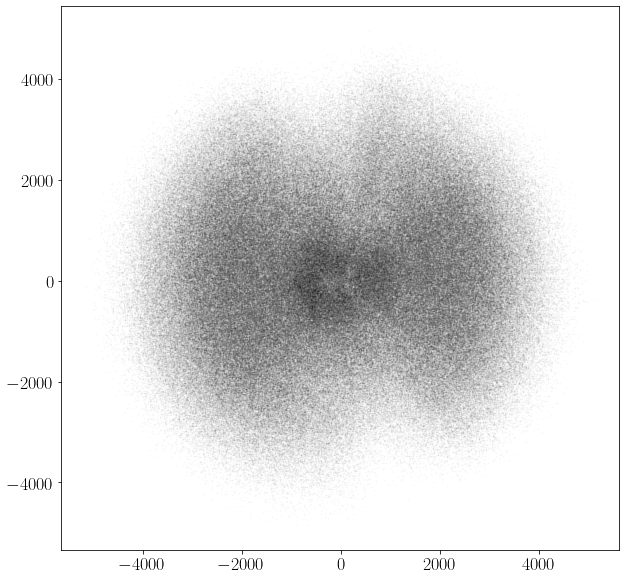

In [58]:
plt.figure(figsize=(10,10))
plt.scatter(tab_gaia['x'], tab_gaia['y'], s=1, alpha=0.03, c='k', marker='.')

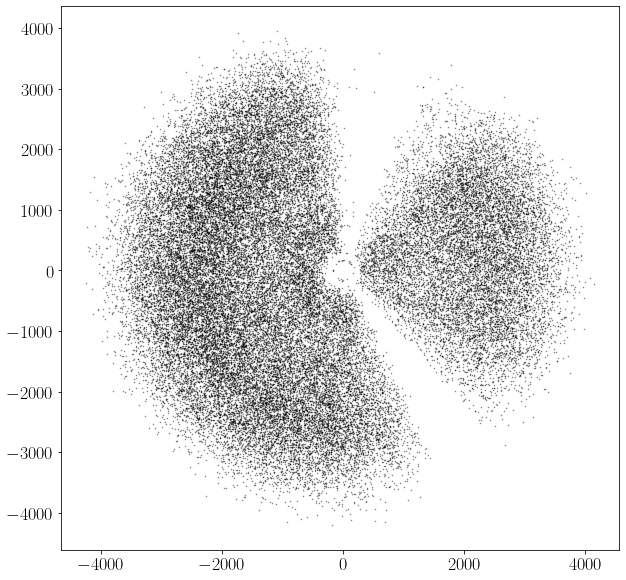

In [86]:
i_slice = (tab_gaia['dec'] > 30) & (tab_gaia['dec'] < 40)
plt.figure(figsize=(10,10))
plt.scatter(tab_gaia['x'][i_slice], tab_gaia['y'][i_slice], s=1, alpha=0.5, c='k', marker='.')

In [76]:
i_slice = (tab_gaia['x'] >= -1500) & (tab_gaia['x'] < -500) \
        & (tab_gaia['y'] >= -1000) & (tab_gaia['y'] < 0) \
        & (tab_gaia['z'] >= -1000) & (tab_gaia['z'] < 1000)
print(np.sum(i_slice))

12310


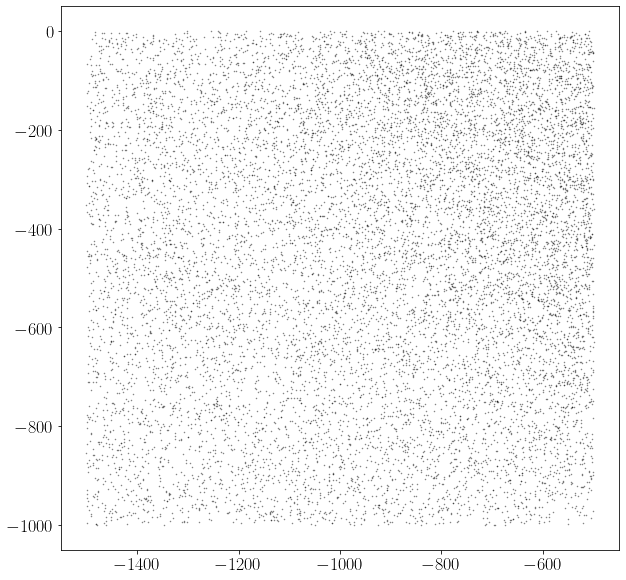

In [77]:
plt.figure(figsize=(10,10))
plt.scatter(tab_gaia['x'][i_slice], tab_gaia['y'][i_slice], s=1, alpha=0.5, c='k', marker='.')

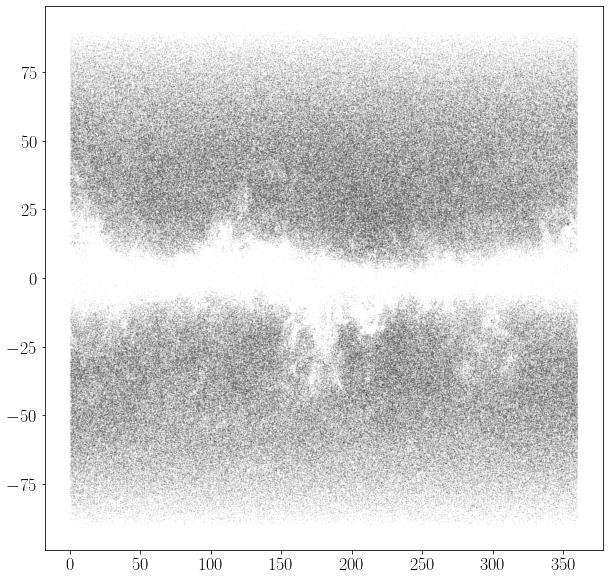

In [87]:
plt.figure(figsize=(10,10))
plt.scatter(tab_gaia['l'], tab_gaia['b'], s=1, alpha=0.05, c='k', marker='.')

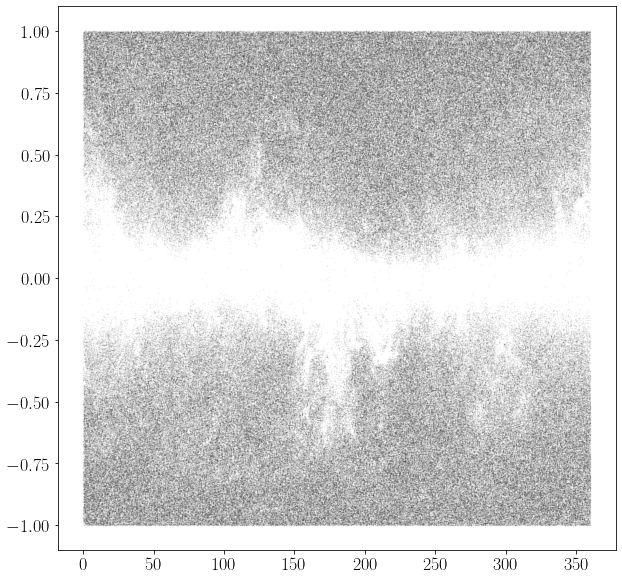

In [54]:
plt.figure(figsize=(10,10))
b_rad = tab_gaia["b"] * np.pi/180
plt.scatter(tab_gaia['l'], np.sin(b_rad), s=1, alpha=0.05, c='k', marker='.')

In [51]:
#theta, phi = utils.radec_to_spherical(tab_gaia['ra'], tab_gaia['dec'])
theta, phi = utils.radec_to_spherical(tab_gaia['l'], tab_gaia['b'])

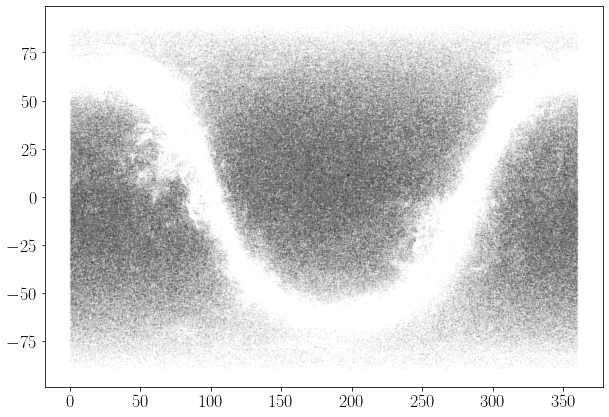

In [80]:
plt.figure(figsize=(10,7))
plt.scatter(tab_gaia['ra'], tab_gaia['dec'], s=1, alpha=0.03, c='k', marker='.')

In [8]:
i_slice = (tab_gaia['dec'] > -5) & (tab_gaia['dec'] < 5)

In [9]:
np.min(tab_gaia['ra']), np.max(tab_gaia['ra'])

(0.00026225516912966034, 359.9997557589368)

In [10]:
ra_rad = tab_gaia['ra']*(np.pi/180)

In [12]:
print(min(tab_gaia['dist'][i_slice]), max(tab_gaia['dist'][i_slice]))

193.0579409261554 5159.937115044537


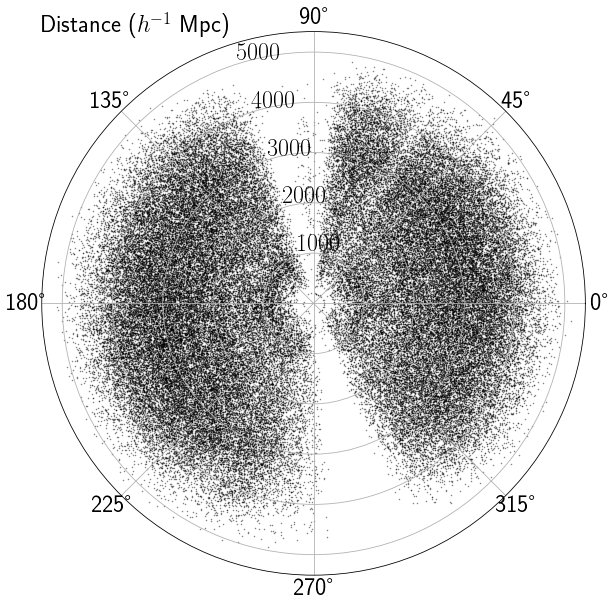

In [27]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10,10))
ax.scatter(ra_rad[i_slice], tab_gaia['dist'][i_slice], s=1, marker='.', alpha=0.5, color='k')
#ax.set_rmax(2)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)
rs = tab_gaia['dist'][i_slice]
rticks = [1000, 2000, 3000, 4000, 5000]
ax.set_rticks(rticks)  # Less radial ticks
ax.set_rlabel_position(108) 
ax.text(0, 1, 'Distance ($h^{-1}$ Mpc)', transform=ax.transAxes, fontsize=24)

ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=24)

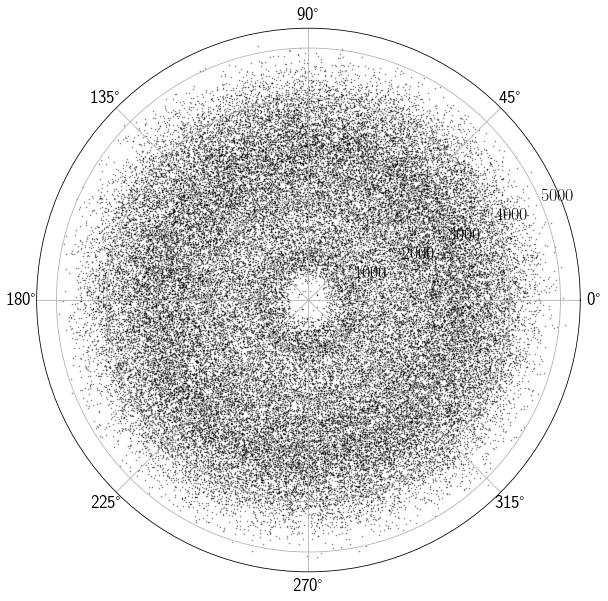

In [89]:
i_slice = (tab_gaia['b'] > 30) & (tab_gaia['b'] < 40)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10,10))
ax.scatter(tab_gaia['l'][i_slice], tab_gaia['dist'][i_slice], s=1, marker='.', alpha=0.5, color='k')
#ax.set_rmax(2)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

In [92]:
np.min(b_rad), np.max(b_rad)

(-1.570431715075202, 1.5684005462324089)

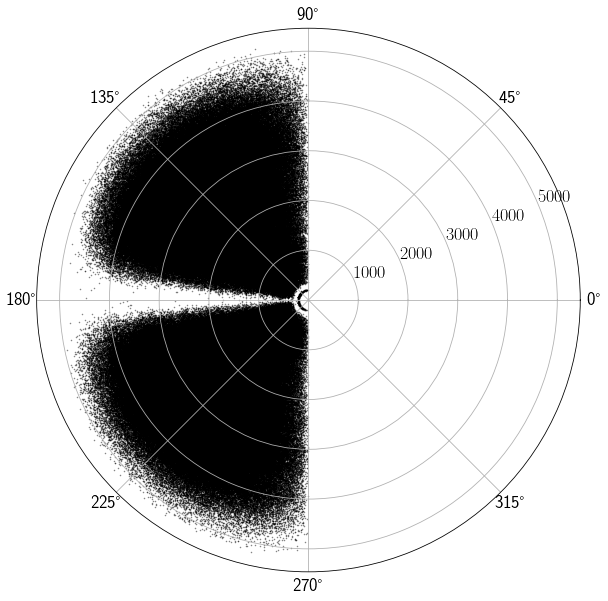

In [93]:
#i_slice = (tab_gaia['b'] > 30) & (tab_gaia['b'] < 40)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10,10))
ax.scatter(b_rad+np.pi, tab_gaia['dist'], s=1, marker='.', alpha=0.5, color='k')
#ax.set_rmax(2)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

# 3d

In [11]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.
    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [212]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker

def plot_3d(data, c, s, alpha, lim, cmap, vmin, vmax, elev=10.):

    fig = plt.figure(figsize=(10,10))
    ax = Axes3D(fig)
    #fig = plt.figure(figsize=(10,10))
    #ax = fig.add_subplot(projection='3d')
    #cmap = 'plasma_r'
    scat = ax.scatter(data['x'], data['y'], data['z'], c=c, s=s, alpha=alpha, 
                      cmap=cmap, vmin=vmin, vmax=vmax)
    ax.axis('off')

    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    #ax.set_facecolor('black')
    norm = matplotlib.colors.Normalize(vmin=0, vmax=np.max(c))
    cc = cm.ScalarMappable(norm=norm, cmap=cmap)
    #cbaxes = fig.add_axes([1.0, 0.2, 0.03, 0.65]) 
    cbaxes = fig.add_axes([0.5, 0.5, 0.01, 0.43]) 
    #fig.colorbar(cc, label=r'redshift $z$', extend='max', fraction=0.033, pad=0.06)
    cbar = fig.colorbar(cc, cax=cbaxes, pad=0.07)
    cbar.set_label(label=r'redshift $z$', fontsize=36)
    cbar.ax.tick_params(labelsize=36)
    #cbar.ax.set_yticklabels([0,1,2,3,4])
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    #ax.view_init(elev, 0)
    plt.tight_layout(pad=0)
    return fig,

In [198]:
scmap = shiftedColorMap(cm.plasma_r, start=0.2, midpoint=0.6, stop=1.0, name='plasma_shifted')

/state/partition1/job-26095809/ipykernel_1322212/4118539024.py:47: UserWarning: Trying to register the cmap 'plasma_shifted' which already exists.
  plt.register_cmap(cmap=newcmap)


/state/partition1/job-26095809/ipykernel_1322212/3723161272.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
/state/partition1/job-26095809/ipykernel_1322212/3723161272.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0)


(<Figure size 720x720 with 2 Axes>,)

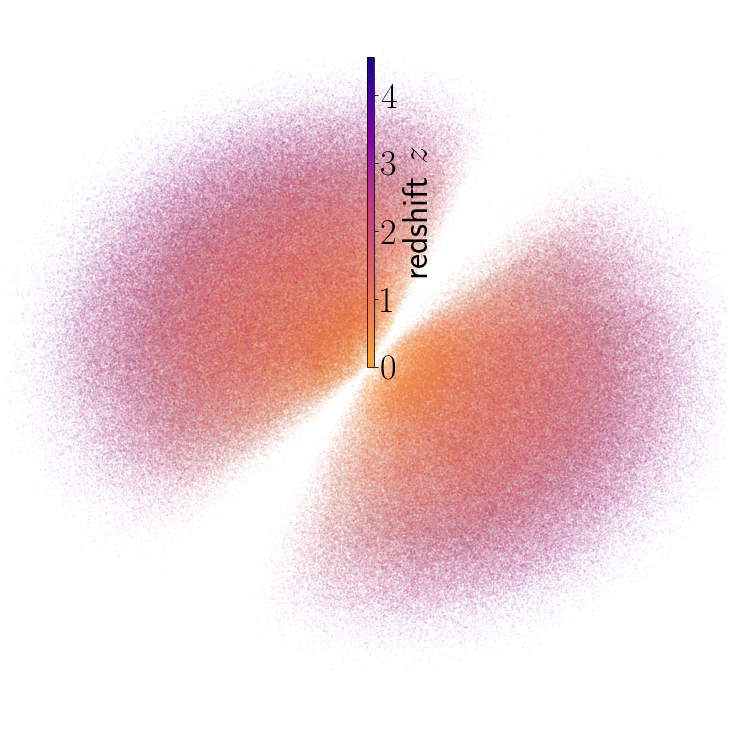

In [213]:
plot_3d(tab_gaia, tab_gaia['redshift_spz'], 0.7, 0.05, 3000, scmap, 0, 4.5)

# 2D 

In [165]:
area_per_pixel = hp.nside2pixarea(NSIDE, degrees=True)
print(f"Area per pixel: {area_per_pixel:.3f} deg")

Area per pixel: 0.210 deg


In [ ]:
scmap = shiftedColorMap(cm.plasma_r, start=0.2, midpoint=0.6, stop=1.0, name='plasma_shifted')

[<matplotlib.patches.Rectangle object at 0x152c4bf028f0>, <HpxMollweideAxes:>, <Axes:label='<colorbar>'>]
[<matplotlib.patches.Polygon object at 0x152c4bfa6aa0>, <matplotlib.collections.LineCollection object at 0x152c4bfa7be0>, <matplotlib.collections.QuadMesh object at 0x152c4bf93580>, Text(0.5, -1.0, 'number density of quasars (deg$^{-2}$)'), <matplotlib.spines.Spine object at 0x152c4bf92560>, <matplotlib.spines.Spine object at 0x152c4bf92680>, <matplotlib.spines.Spine object at 0x152c4bf927a0>, <matplotlib.spines.Spine object at 0x152c4bf928c0>, <matplotlib.colorbar._ColorbarSpine object at 0x152c4bf921a0>, <matplotlib.axis.XAxis object at 0x152c4bf92500>, <matplotlib.axis.YAxis object at 0x152c4bf92da0>, Text(0.5, 1.0, ''), Text(0.0, 1.0, ''), Text(1.0, 1.0, ''), <matplotlib.patches.Rectangle object at 0x152c4bfa57e0>]


AttributeError: 'LineCollection' object has no attribute 'set_fontsize'

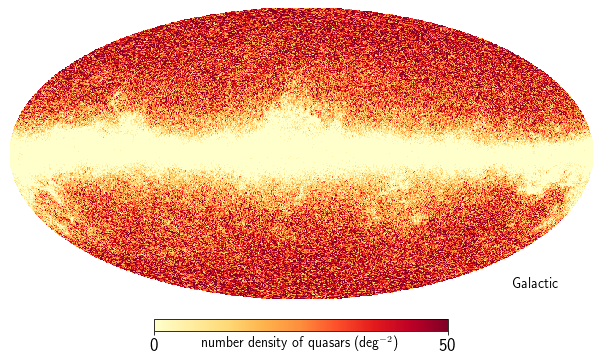

In [193]:
dens_data = map_nqso_data / area_per_pixel
hp.mollview(dens_data, title=None,
             unit=r"number density of quasars (deg$^{-2}$)", cmap='YlOrRd', coord=['C', 'G'], 
             min=0, max=50)
f = matplotlib.pyplot.gcf().get_children()
print(f)
HpxAx = f[1]
CbAx = f[2]
print(CbAx.get_children())
unit_text_obj = CbAx.get_children()[1]
unit_text_obj.set_fontsize(36)

In [171]:
1e6/42000

23.80952380952381

## Redshifts

Text(0, 0.5, '$z_{SPZ}$, spectro-photometric redshift')

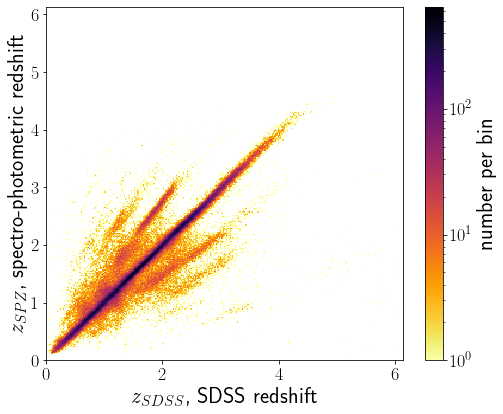

In [9]:
z_bins = np.linspace(0, np.max(tab_gaia['redshift_qsoc']), 300)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(tab_gaia['redshift_sdss'], tab_gaia['redshift_spz'], bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ}$, spectro-photometric redshift')

In [14]:
np.max(tab_gaia['redshift_sdss'])

7.011244773864746

(0.0, 6.0)

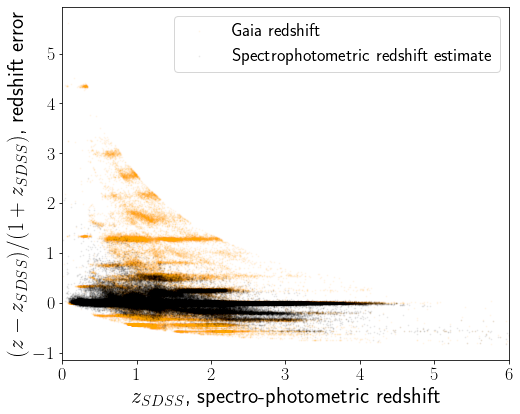

In [25]:
z_bins = np.linspace(0, np.max(tab_gaia['redshift_qsoc']), 300)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
err_spz = (tab_gaia['redshift_spz']-tab_gaia['redshift_sdss'])/(1+tab_gaia['redshift_sdss'])
err_qsoc = (tab_gaia['redshift_qsoc']-tab_gaia['redshift_sdss'])/(1+tab_gaia['redshift_sdss'])
#h = ax.hist2d(tab_gaia['redshift_sdss'], err_spz, bins=z_bins, cmin=1, cmap='inferno_r',
#             norm=matplotlib.colors.LogNorm())
h = ax.scatter(tab_gaia['redshift_sdss'], err_qsoc, s=1, c='orange', alpha=0.05,
            label='Gaia redshift')
h = ax.scatter(tab_gaia['redshift_sdss'], err_spz, s=1, c='k', alpha=0.05,
            label='Spectrophotometric redshift estimate')
#fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, spectro-photometric redshift')
plt.ylabel(r'$(z - z_{SDSS})/(1+z_{SDSS})$, redshift error')

plt.legend()
plt.xlim(0,6)

(0.0, 6.0)

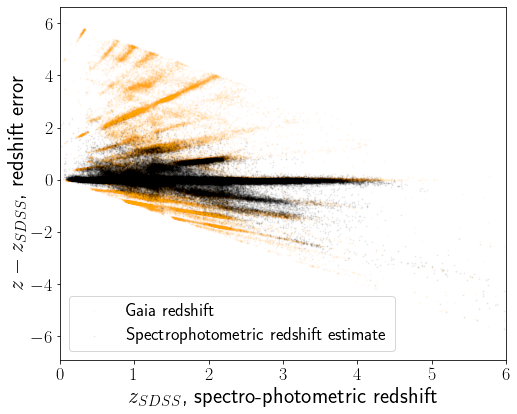

In [26]:
z_bins = np.linspace(0, np.max(tab_gaia['redshift_qsoc']), 300)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
err_spz = (tab_gaia['redshift_spz']-tab_gaia['redshift_sdss'])
err_qsoc = (tab_gaia['redshift_qsoc']-tab_gaia['redshift_sdss'])
#h = ax.hist2d(tab_gaia['redshift_sdss'], err_spz, bins=z_bins, cmin=1, cmap='inferno_r',
#             norm=matplotlib.colors.LogNorm())
h = ax.scatter(tab_gaia['redshift_sdss'], err_qsoc, s=1, c='orange', alpha=0.05, 
               label='Gaia redshift')
h = ax.scatter(tab_gaia['redshift_sdss'], err_spz, s=1, c='k', alpha=0.05,
               label='Spectrophotometric redshift estimate')
#fig.colorbar(h[3], ax=ax, label='number per bin')

plt.legend()
plt.xlabel(r'$z_{SDSS}$, spectro-photometric redshift')
plt.ylabel(r'$z - z_{SDSS}$, redshift error')

plt.xlim(0,6)

In [ ]:
z_bins = np.linspace(0, np.max(tab_gaia['redshift_qsoc']), 300)
fig, ax = plt.subplots(1, 1, figsize = (8, 8))

h = ax.scatter(tab_gaia['redshift_sdss'], tab_gaia['redshift_qsoc'], s=1, c='orange', alpha=0.05, 
               label='Gaia redshift')
h = ax.scatter(tab_gaia['redshift_sdss'], tab_gaia['redshift_spz'], s=1, c='k', alpha=0.05,
               label='Spectrophotometric redshift estimate')

plt.legend()
plt.xlabel(r'$z_{SDSS}$, spectro-photometric redshift')
plt.ylabel(r'$z - z_{SDSS}$, redshift error')

plt.xlim(0,6)
plt.ylim(0,6)

# animation prep

In [9]:
import animate

In [12]:
scmap = shiftedColorMap(cm.plasma_r, start=0.2, midpoint=0.6, stop=1.0, name='plasma_shifted')

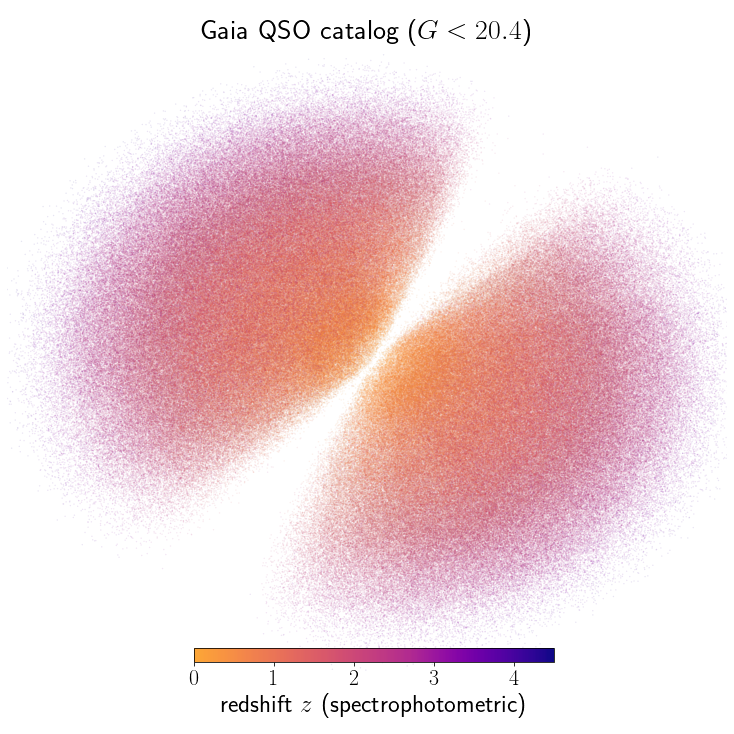

In [13]:
s = 0.15
alpha = 0.12
lim = 3000
#vmin, vmax = -28, -20
vmin, vmax = 0, 4.5

property_colorby = 'redshift_spz'
title = 'Gaia QSO catalog ($G<20.4$)'
colorbar_label = r'redshift $z$ (spectrophotometric)'
animate.make_anim(tab_gaia, tab_gaia[property_colorby], s, alpha, lim, vmin, vmax, 
                  cmap=scmap, title=title, colorbar_label=colorbar_label)

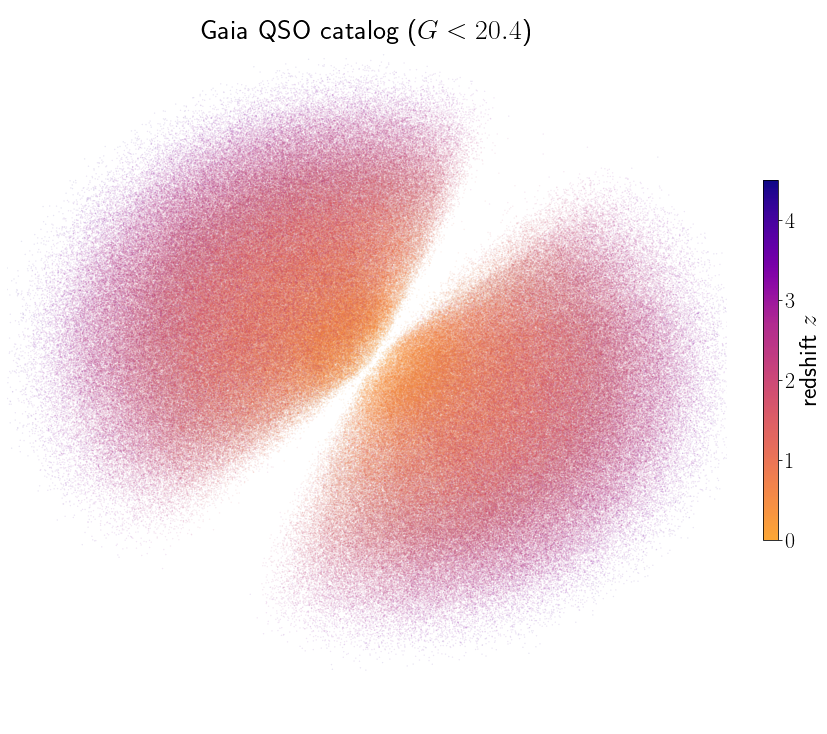

In [16]:
s = 0.15
alpha = 0.12
lim = 3000
#vmin, vmax = -28, -20
vmin, vmax = 0, 4.5

property_colorby = 'redshift_spz'
title = 'Gaia QSO catalog ($G<20.4$)'
colorbar_label = r'redshift $z$'
animate.make_anim(tab_gaia, tab_gaia[property_colorby], s, alpha, lim, vmin, vmax, 
                  cmap=scmap, title=title, colorbar_label=colorbar_label)

In [41]:
fn_sdss = f'../data/sdss_slim.fits'
tab_sdss = utils.load_table(fn_sdss)
print(len(tab_sdss))

750414


In [46]:
tab_sdss.keys()

['SDSS_NAME', 'RA', 'DEC', 'Z', 'OBJID']

In [47]:
cosmo = astropy.cosmology.Planck15
redshift_name_data = 'Z'
add_dist(tab_sdss, cosmo, redshift_name_data) 

/ext3/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/astropy/cosmology/flrw/base.py:1076: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(self._inv_efunc_scalar, z1, z2, args=self._inv_efunc_scalar_args)[0]
/ext3/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/numpy/lib/function_base.py:2387: RuntimeWarning: invalid value encountered in _integral_comoving_distance_z1z2_scalar (vectorized)
  outputs = ufunc(*inputs)


In [48]:
add_xyz(tab_sdss, ra_name='RA', dec_name='DEC') 

(array([1650.32659591, 3112.34483929, 3103.26511   , ..., 2663.42200559,
        3374.4733451 , 3239.27588048]),
 array([ 0.01813186,  0.07683705,  0.08315895, ..., -0.01788568,
        -0.01418797, -0.00259333]),
 array([1177.94204356, 1874.30564826,  384.55927889, ...,  152.10685056,
        1276.52616778, 2246.92557549]))

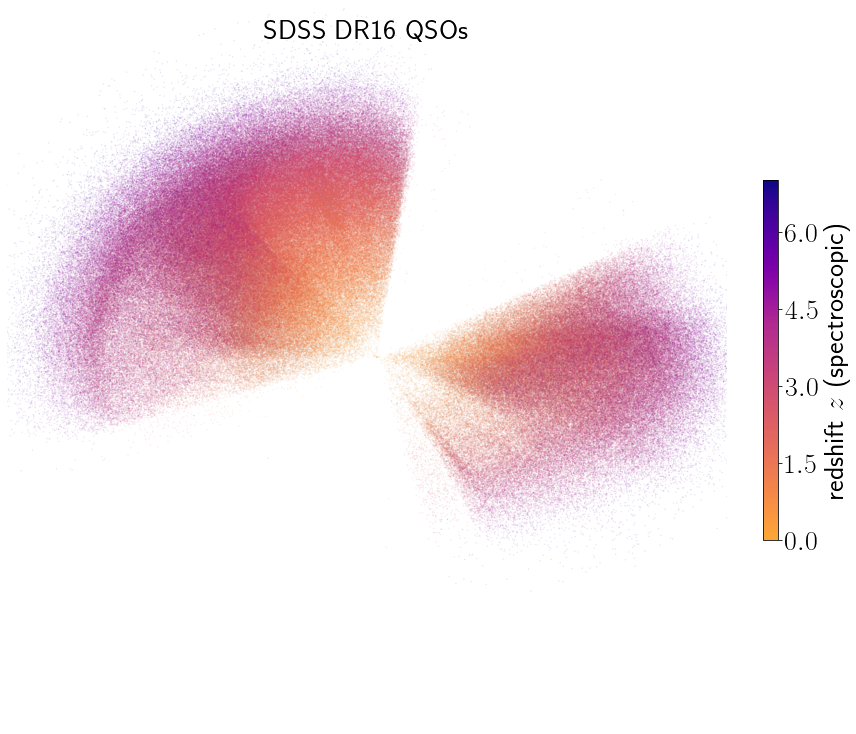

In [49]:
s = 0.15
alpha = 0.12
lim = 3000
#vmin, vmax = -28, -20
vmin, vmax = 0, 4.5

property_colorby = 'Z'
title = 'SDSS DR16 QSOs'
colorbar_label = r'redshift $z$ (spectroscopic)'
animate.make_anim(tab_sdss, tab_sdss[property_colorby], s, alpha, lim, vmin, vmax,
                  cmap=scmap, title=title, colorbar_label=colorbar_label)

In [55]:
redshift = np.concatenate((tab_gaia['redshift_spz'], tab_sdss['Z']))
x = np.concatenate((tab_gaia['x'], tab_sdss['x']))
y = np.concatenate((tab_gaia['y'], tab_sdss['y']))
z = np.concatenate((tab_gaia['z'], tab_sdss['z']))
data_cols = [redshift, x, y, z]
col_names = ['redshift', 'x', 'y', 'z']
tab_comb = Table(data_cols, names=col_names)

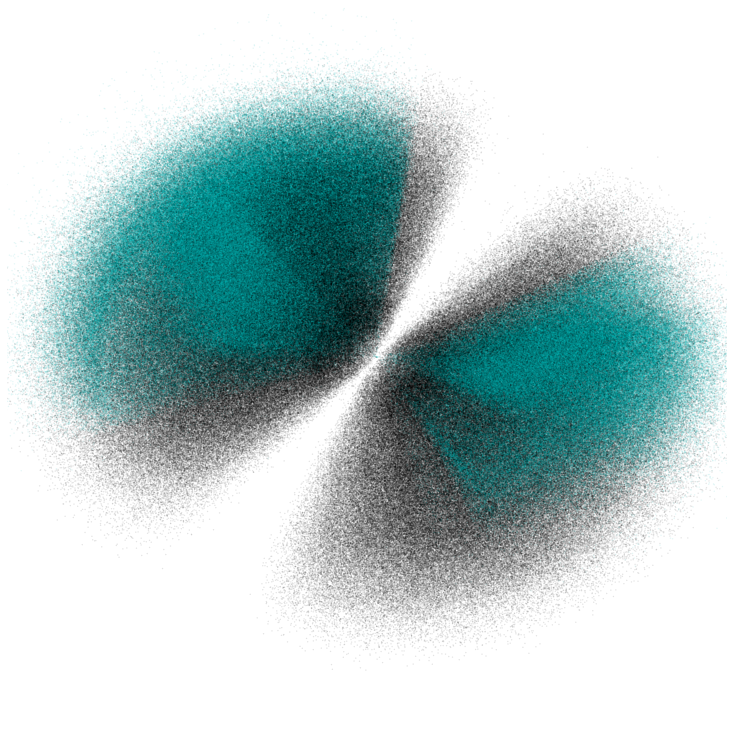

In [61]:
s = 0.15
alpha = 0.12
lim = 3000
vmin, vmax = 0, 4.5

property_colorby = 'redshift'
title = ''
#title = 'SDSS DR16 QSOs'
colorbar_label = r'redshift $z$'
c = np.concatenate((['k']*len(tab_gaia), ['c']*len(tab_sdss)))
animate.make_anim(tab_comb, c, s, alpha, lim, vmin, vmax,
                  cmap=scmap, title=title, colorbar_label=colorbar_label, colorbar=False)